In [6]:
import numpy as np
import pylab as pb
import GPy
import copy as cp

import pickle

import matplotlib as mpl

pb.ion()

file_base = ""

In [7]:
X_raw = np.load("hc_G6_test.npy", allow_pickle=True)
Y_raw = np.load("samples_G6_test.npy", allow_pickle=True)
# Emulator version label, for plots
emu_vlabel = "G7a"

In [8]:
scales = np.load("../standard_k.npy", allow_pickle=True)

In [9]:
def is_bad(row):
    if float('-inf') in row or float('inf') in row \
        or None in row or True in np.isnan(pspec) \
        or 0 in row:
        return True
    return False

bad_row_indices = []
for i in range(len(Y_raw)):
    pspec = Y_raw[i]
    if is_bad(pspec):
        bad_row_indices.append(i)

X = np.delete(X_raw, bad_row_indices, 0)
Y = np.delete(Y_raw, bad_row_indices, 0)

In [10]:
m = pickle.load(open("analyses/massive_emulator_" + emu_vlabel + ".nucomet", "rb"))

In [11]:
def inverse_ytransform(raw_prediction):
    return np.exp(raw_prediction * m.ystdev + m.ymu)

In [12]:
#def xtransform(configuration):
#    return (configuration - m.xmu) / m.xstdev

def xtransform(configuration):
    return (configuration - m.xmu) / m.xstdev

In [13]:
def nest(array):
    return np.array([np.array(array)])

In [14]:
preds = np.zeros(Y.shape)
rel_errors = np.zeros(Y.shape)
sq_errors = np.zeros(Y.shape)

for i in range(len(X)):
    x = xtransform(nest(X[i]))
    raw_pred, _ = m.predict(x)
    preds[i] = inverse_ytransform(raw_pred)
    rel_errors[i] = preds[i] - Y[i]
    sq_errors[i] = np.square(preds[i] - Y[i])

In [15]:
print("Squared error across all models:")
print(sum(sum(sq_errors)))

Squared error across all models:
212194251.71253303


[2.15785750e-02 1.36177000e-01 9.73865000e-01 8.32239993e-01
 2.56269744e-09 6.73700000e-03]


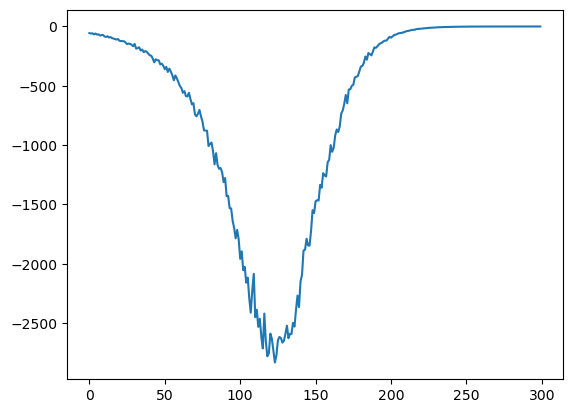

In [16]:
# An example of an extreme error plot, with the cosmology it was
# supposed to describe. 

pb.plot(rel_errors[900] * 100)
print(X[900])

In [17]:
min(X[:, 3])

0.20008000060333042

In [18]:
max(X[:, 3])

0.9999201620474477

In [19]:
def normalize(array):
    min_ = min(array)
    max_ = max(array)
    range_ = max_ - min_
    shifted = array - min_
    return shifted / range_

In [20]:
# Let's use the plasma color map
def plot_colored_errors(param_index, param_label, param_range=None,
    save_label=None):
    valid_indices = list(range(len(X[:, param_index])))
    if param_range is not None:
        valid_indices = np.where(np.logical_and(
            X[:, param_index] < param_range[1],
            X[:, param_index] > param_range[0]))[0]
    valid_vals = X[:, param_index][valid_indices]
    normalized_vals = normalize(valid_vals)
    # normalized_vals = normalize(X[:, param_index])
    colors = pb.cm.plasma(normalized_vals)
    valid_errors = rel_errors[valid_indices]
    
    for i in range(len(valid_errors)):
        if i % 1 == 0:
            pb.plot(scales, valid_errors[i],
                color=colors[i], alpha=0.05)
            pb.xscale('log')

    pb.title(r"Emulator " + emu_vlabel + ", " + str(len(valid_errors)) + \
             r" Random Massive-$\nu$ Models" + "\ncolored by " + \
             param_label + " value")
    pb.ylabel("% error between CAMB and CassL")
    pb.xlabel("scale $k$ [1 / Mpc]")
    norm = mpl.colors.Normalize(
        vmin=min(X[:, param_index][valid_indices]),
        vmax=max(X[:, param_index][valid_indices]))
    pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma, norm=norm))
    # Momentarily eliminate saving so that we don't keep crashing on the
    # incomplete file handles.
    if save_label is not None:
        pb.savefig("../../plots/emulator/performance/" + save_label + ".png")

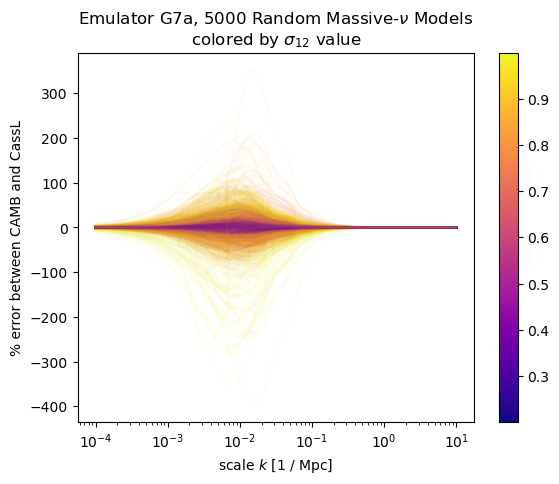

In [21]:
plot_colored_errors(3, r"$\sigma_{12}$", save_label=emu_vlabel + \
                    "_s12_coloration")

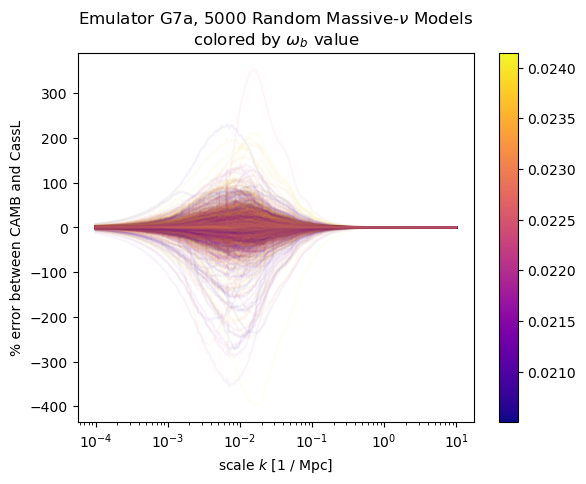

In [22]:
plot_colored_errors(0, r"$\omega_b$", save_label=emu_vlabel + \
                    "_ombh2_coloration")

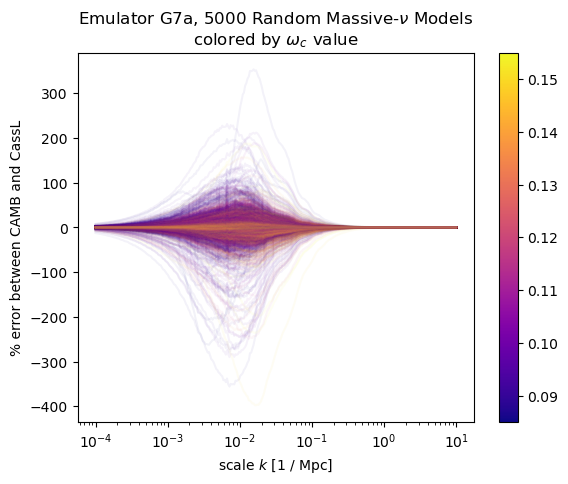

In [23]:
plot_colored_errors(1, r"$\omega_c$", save_label=emu_vlabel + \
                    "_omch2_coloration")

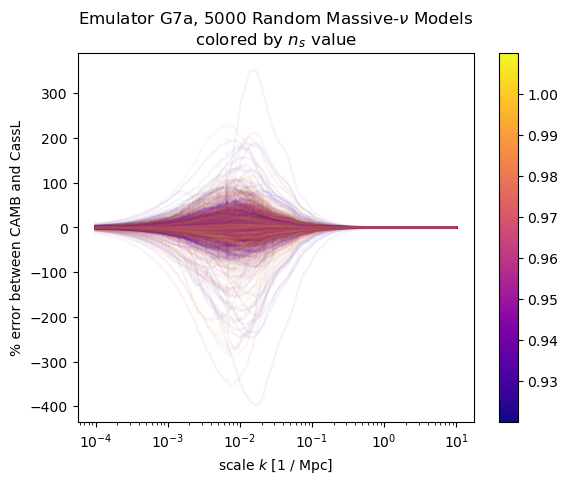

In [24]:
plot_colored_errors(2, r"$n_s$", save_label=emu_vlabel + \
                    "_ns_coloration")

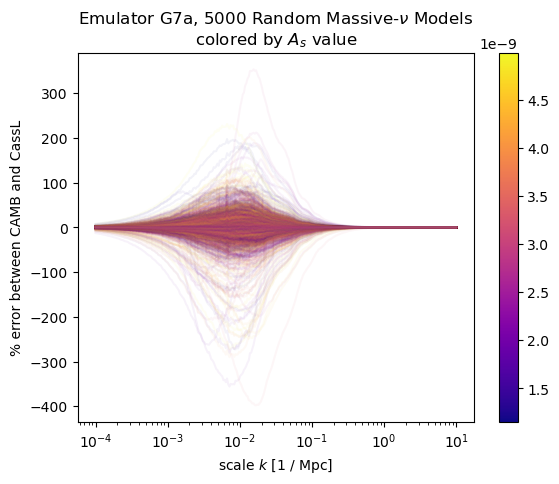

In [25]:
plot_colored_errors(4, r"$A_s$", save_label=emu_vlabel + \
                    "_As_coloration")

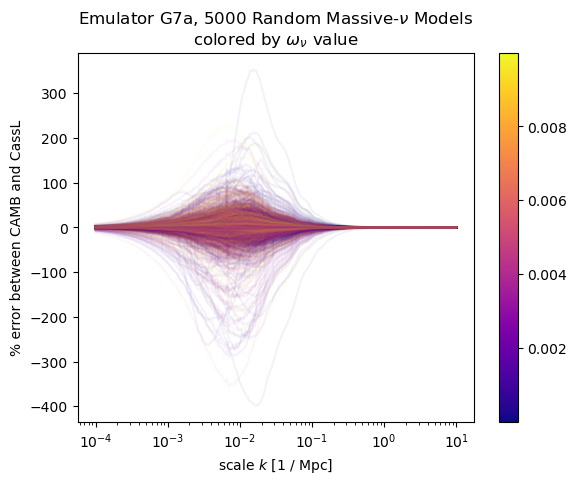

In [26]:
plot_colored_errors(5, r"$\omega_\nu$", save_label=emu_vlabel + \
                    "_omnuh2_coloration")

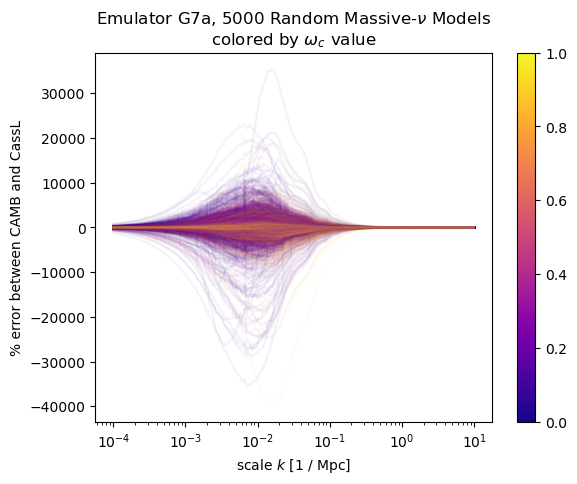

In [27]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

# Let's use the plasma color map
normalized_omc_vals = normalize(X[:, 1])
colors_omc = pb.cm.plasma(normalized_omc_vals)

for i in range(len(rel_errors)):
    if i % 1 == 0:
        pb.plot(scales, 100 * rel_errors[i],
            color=colors_omc[i], alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_c$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.colorbar(mpl.cm.ScalarMappable(cmap=pb.cm.plasma))
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

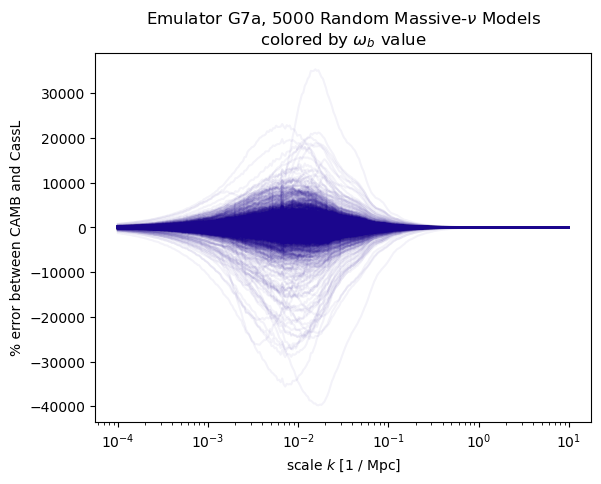

In [28]:
# This cell is wrong, right? It must be a leftover... it doesn't seem to have
# anything that the already-correct solution above lacks...

for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color=pb.cm.plasma(X[i][0]), alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models" "\n" 
        r"colored by $\omega_b$ value")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")

Text(0.5, 0, 'scale $k$ [1 / Mpc]')

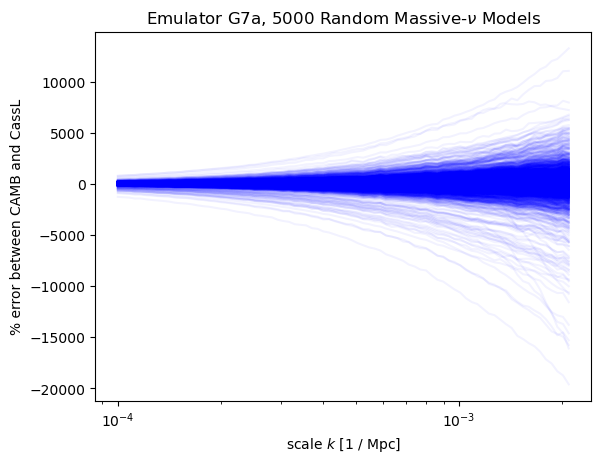

In [29]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales[:80], 100 * rel_errors[i][:80],
            color='blue', alpha=0.05)
        pb.xscale('log')
        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
#pb.savefig("../plots/emulator/performance/massive_5k_G6.png")

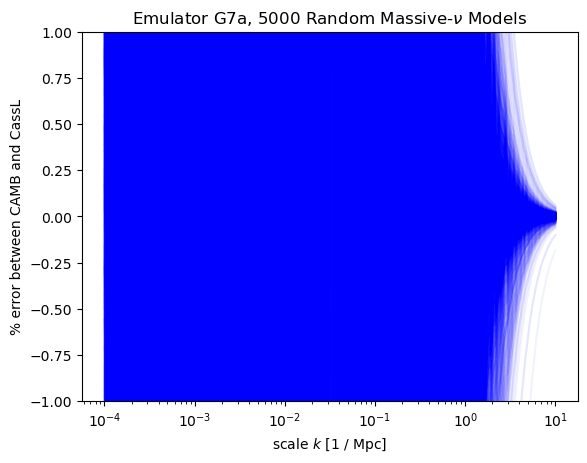

In [30]:
for i in range(len(rel_errors)):
    if i % 1 == 0: # plot one out of every one hundred errors
        pb.plot(scales, 100 * rel_errors[i],
            color='blue', alpha=0.05)
        pb.xscale('log')

pb.ylim((-1, 1))        
pb.title(r"Emulator " + emu_vlabel + r", 5000 Random Massive-$\nu$ Models")
pb.ylabel("% error between CAMB and CassL")
pb.xlabel("scale $k$ [1 / Mpc]")
pb.savefig("../../plots/emulator/performance/massive_5k_" + emu_vlabel + ".png")

In [31]:
# Error statistics ideas: parentheticals describe building blocks

# (for each curve:)
    # a minimum percent error
    # b maximum percent error
    # c standard deviation of errors
    # d mean error
    # e median error

# Median, mean, stddev of a-e.

mins = np.array([min(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MINIMUM RELATIVE ERRORS:")
print("this ranges from", min(mins), "to", max(mins))
print("median is", np.median(mins))
print("mean is", np.mean(mins))
print("st.dev. is", np.std(mins))

MINIMUM RELATIVE ERRORS:
this ranges from 3.869456977056984e-10 to 0.0018332431571658203
median is 2.5507618275306954e-05
mean is 4.416299488956912e-05
st.dev. is 6.739354541952561e-05


In [32]:
maxs = np.array([max(abs(rel_error_curve)) for rel_error_curve in rel_errors])
print("MAXIMUM RELATIVE ERRORS:")
print("this ranges from", min(maxs), "to", max(maxs))
print("median is", np.median(maxs))
print("mean is", np.mean(maxs))
print("st.dev. is", np.std(maxs))

MAXIMUM RELATIVE ERRORS:
this ranges from 0.2438551162567819 to 397.8504092398507
median is 11.458589568848765
mean is 18.864970012872234
st.dev. is 25.47425374149938


In [33]:
means = np.array([np.mean(rel_error_curve) for rel_error_curve in rel_errors])
print("MEAN RELATIVE ERRORS:")
print("this ranges from", min(means), "to", max(means))
print("median is", np.median(means))
print("mean is", np.mean(means))
print("st.dev. is", np.std(means))

MEAN RELATIVE ERRORS:
this ranges from -93.75296779371818 to 55.97717211781643
median is 0.07934498323786895
mean is -0.004555935147509496
st.dev. is 7.060012594235212


In [34]:
meds = np.array([np.median(rel_error_curve) for rel_error_curve in rel_errors])
print("MEDIAN RELATIVE ERRORS:")
print("this ranges from", min(meds), "to", max(meds))
print("median is", np.median(meds))
print("mean is", np.mean(meds))
print("st.dev. is", np.std(meds))

MEDIAN RELATIVE ERRORS:
this ranges from -34.63192536853148 to 19.187393206377237
median is 5.431314795426023e-05
mean is -0.00035982514035752614
st.dev. is 2.352917612850233


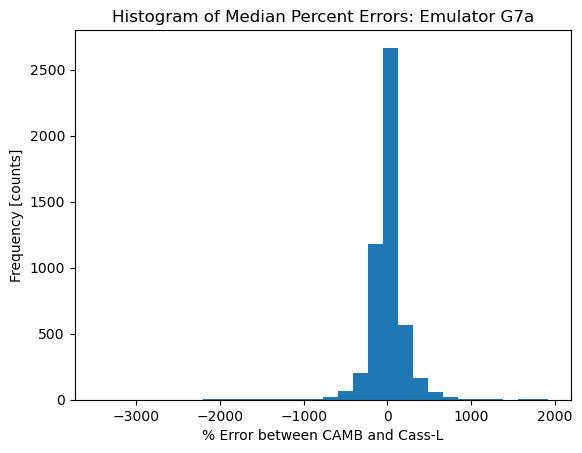

In [35]:
pb.hist(100 * meds, bins=30)
pb.title("Histogram of Median Percent Errors: Emulator " + emu_vlabel)
pb.ylabel("Frequency [counts]")
pb.xlabel("% Error between CAMB and Cass-L")
pb.savefig("../../plots/emulator/performance/err_hist_" + emu_vlabel + ".png")

In [36]:
stddevs = np.array([np.std(rel_error_curve) for rel_error_curve in rel_errors])
print("ST.DEV.S IN RELATIVE ERRORS:")
print("this ranges from", min(stddevs), "to", max(stddevs))
print("median is", np.median(stddevs))
print("mean is", np.mean(stddevs))
print("st.dev. is", np.std(stddevs))

ST.DEV.S IN RELATIVE ERRORS:
this ranges from 0.0472522081393712 to 120.18371583534791
median is 3.304831560978603
mean is 5.551054822032762
st.dev. is 7.797744946489588


(array([4.838e+03, 1.270e+02, 2.600e+01, 6.000e+00, 0.000e+00, 2.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00]),
 array([3.86945698e-10, 1.83324664e-04, 3.66648941e-04, 5.49973218e-04,
        7.33297495e-04, 9.16621772e-04, 1.09994605e-03, 1.28327033e-03,
        1.46659460e-03, 1.64991888e-03, 1.83324316e-03]),
 <BarContainer object of 10 artists>)

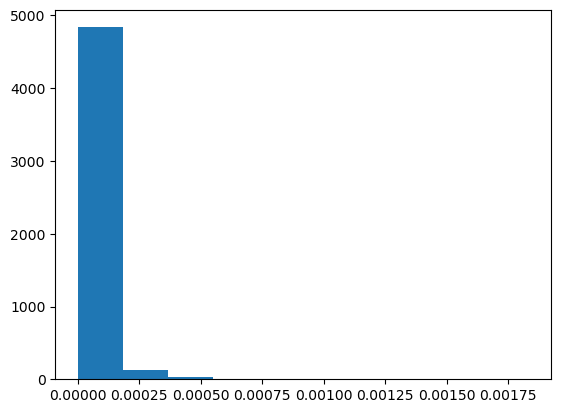

In [37]:
pb.hist(mins)

(array([4.496e+03, 3.810e+02, 7.400e+01, 2.000e+01, 9.000e+00, 9.000e+00,
        6.000e+00, 2.000e+00, 2.000e+00, 1.000e+00]),
 array([2.43855116e-01, 4.00045105e+01, 7.97651659e+01, 1.19525821e+02,
        1.59286477e+02, 1.99047132e+02, 2.38807788e+02, 2.78568443e+02,
        3.18329098e+02, 3.58089754e+02, 3.97850409e+02]),
 <BarContainer object of 10 artists>)

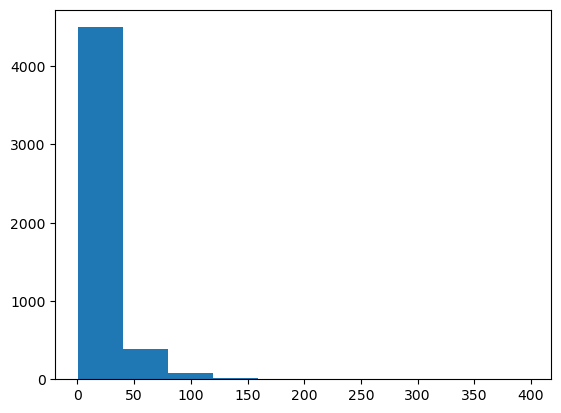

In [38]:
pb.hist(maxs)

(array([4.508e+03, 3.720e+02, 7.000e+01, 1.700e+01, 1.200e+01, 8.000e+00,
        6.000e+00, 4.000e+00, 1.000e+00, 2.000e+00]),
 array([4.72522081e-02, 1.20608986e+01, 2.40745449e+01, 3.60881913e+01,
        4.81018377e+01, 6.01154840e+01, 7.21291304e+01, 8.41427767e+01,
        9.61564231e+01, 1.08170069e+02, 1.20183716e+02]),
 <BarContainer object of 10 artists>)

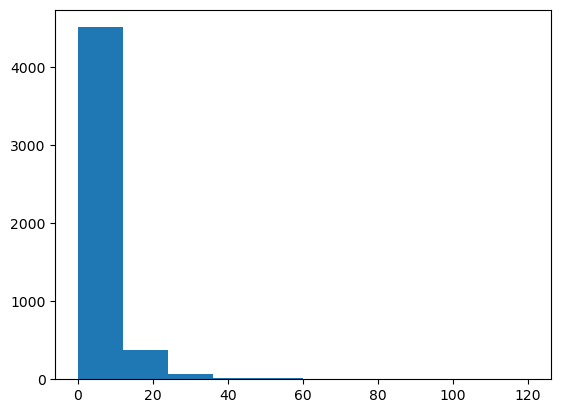

In [39]:
pb.hist(stddevs)

(array([2.00e+00, 1.00e+00, 7.00e+00, 1.10e+01, 1.70e+01, 2.93e+02,
        4.41e+03, 2.43e+02, 1.10e+01, 5.00e+00]),
 array([-34.63192537, -29.24999351, -23.86806165, -18.4861298 ,
        -13.10419794,  -7.72226608,  -2.34033422,   3.04159763,
          8.42352949,  13.80546135,  19.18739321]),
 <BarContainer object of 10 artists>)

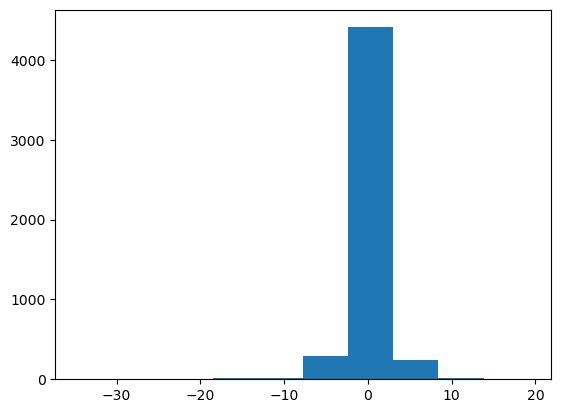

In [40]:
pb.hist(meds)

(array([2.000e+00, 3.000e+00, 9.000e+00, 1.400e+01, 2.900e+01, 6.860e+02,
        4.077e+03, 1.650e+02, 1.000e+01, 5.000e+00]),
 array([-93.75296779, -78.7799538 , -63.80693981, -48.83392582,
        -33.86091183, -18.88789784,  -3.91488385,  11.05813014,
         26.03114414,  41.00415813,  55.97717212]),
 <BarContainer object of 10 artists>)

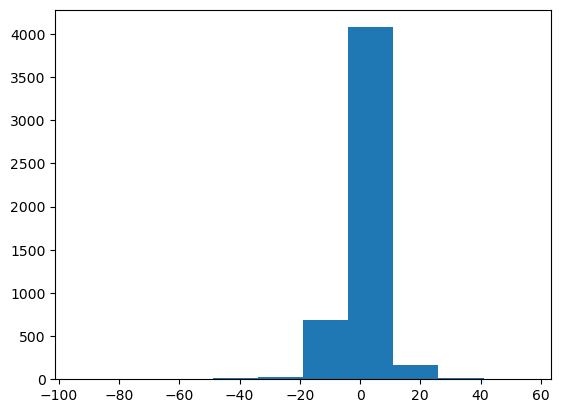

In [41]:
pb.hist(means)